## Data Preparation Check

## Introduction
In this notebook, we will:
- Ensure the time index is properly formatted and continuous
- Check for stationarity and apply transformations if needed (for SARIMAX)
- Identify and handle missing values and outliers
- Confirm that we have sufficient historical data and an appropriate frequency
- Show that the prepared data is suitable for SARIMAX and Prophet modeling

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "data//combined_for_ts.csv"
df = pd.read_csv(data_path)
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,Unnamed: 0,ds,S&P500_Close,Crude Oil_Close,Silver_Close,Iron_Close,Natural Gas_Close,NYSE Composite_Close,Chinese Yuan_Close,Candian Dollar_Close,Euro_Close,VIX_Close,Interest Rate 10y_Close,Interest Rate 30y_Close,y
0,0,2015-03-09,1173.810059,82.690002,24.417000,148.789993,3.657,7546.589844,0.150240,0.996910,1.396726,19.879999,2.495,3.898,1376.699951
1,1,2015-03-10,1176.189941,81.250000,24.271999,146.000000,3.535,7520.600098,0.150525,0.995718,1.407202,19.030001,2.576,3.999,1371.099976
2,2,2015-03-11,1184.709961,83.080002,24.396999,143.070007,3.431,7571.100098,0.150807,0.987264,1.396433,19.090000,2.491,3.927,1371.199951
3,3,2015-03-12,1165.900024,79.489998,23.764000,140.919998,3.513,7423.649902,0.150734,0.983158,1.393592,20.629999,2.475,3.902,1335.099976
4,4,2015-03-13,1178.170044,81.769997,23.848000,142.880005,3.539,7523.810059,0.150725,0.968054,1.373909,19.790001,2.470,3.888,1343.300049


In [3]:
# Check the Time Index
# Check if there are any duplicates or irregularities in the date column
print("Number of unique dates:", df['ds'].nunique())
print("Number of rows:", len(df))
print("Any duplicates?:", df['ds'].duplicated().any())

# Check the frequency by looking at differences
df['diff'] = df['ds'].diff()
print("\nDate differences:\n", df['diff'].value_counts())

# If it's not a regular frequency, we might consider resampling to a consistent frequency.
# For example, if we want daily frequency:
df = df.set_index('ds')
df = df.asfreq('D')  # This will introduce NaNs on days with no data
df = df.reset_index(drop=False)

print("\nAfter resampling to daily frequency:")
print(df.head(10))


Number of unique dates: 3560
Number of rows: 3560
Any duplicates?: False

Date differences:
 diff
1 days    3559
Name: count, dtype: int64

After resampling to daily frequency:
          ds  Unnamed: 0  S&P500_Close  Crude Oil_Close  Silver_Close  \
0 2015-03-09           0   1173.810059        82.690002     24.417000   
1 2015-03-10           1   1176.189941        81.250000     24.271999   
2 2015-03-11           2   1184.709961        83.080002     24.396999   
3 2015-03-12           3   1165.900024        79.489998     23.764000   
4 2015-03-13           4   1178.170044        81.769997     23.848000   
5 2015-03-14           5   1180.260010        80.559998     23.122999   
6 2015-03-15           6   1183.079956        81.690002     23.125000   
7 2015-03-16           7   1185.619995        82.519997     23.544001   
8 2015-03-17           8   1185.640015        82.550003     23.823999   
9 2015-03-18           9   1182.449951        81.940002     23.398001   

   Iron_Close  Natu

In [4]:
# Handle Missing Values
# Check how many missing values we have now
missing_counts = df.isna().sum()
print("Missing values after resampling:\n", missing_counts)

# If there are missing 'y' values due to non-trading days, we can forward fill or interpolate:
df['y'] = df['y'].ffill()  # or df['y'].interpolate()

print("\nMissing values after filling:\n", df.isna().sum())


Missing values after resampling:
 ds                         0
Unnamed: 0                 0
S&P500_Close               0
Crude Oil_Close            0
Silver_Close               0
Iron_Close                 0
Natural Gas_Close          0
NYSE Composite_Close       0
Chinese Yuan_Close         0
Candian Dollar_Close       0
Euro_Close                 0
VIX_Close                  0
Interest Rate 10y_Close    0
Interest Rate 30y_Close    0
y                          0
diff                       1
dtype: int64

Missing values after filling:
 ds                         0
Unnamed: 0                 0
S&P500_Close               0
Crude Oil_Close            0
Silver_Close               0
Iron_Close                 0
Natural Gas_Close          0
NYSE Composite_Close       0
Chinese Yuan_Close         0
Candian Dollar_Close       0
Euro_Close                 0
VIX_Close                  0
Interest Rate 10y_Close    0
Interest Rate 30y_Close    0
y                          0
diff                  

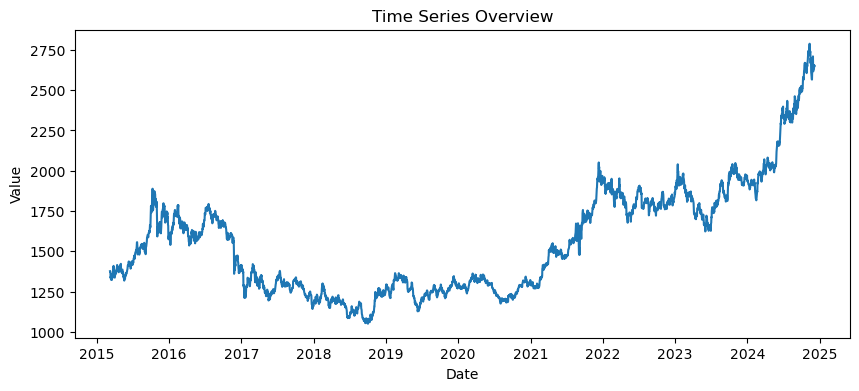

Total observations: 3560
Number of unique years of data: 10


In [5]:
# Check for Sufficient Historical Data and Appropriate Frequency
# Plot the entire series to visually inspect it
plt.figure(figsize=(10,4))
plt.plot(df['ds'], df['y'])
plt.title("Time Series Overview")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

# Check how many observations we have:
print("Total observations:", len(df))

# If we suspect yearly seasonality and we have daily data:
# Ideally, we want at least one full year of data:
unique_years = df['ds'].dt.year.nunique()
print("Number of unique years of data:", unique_years)


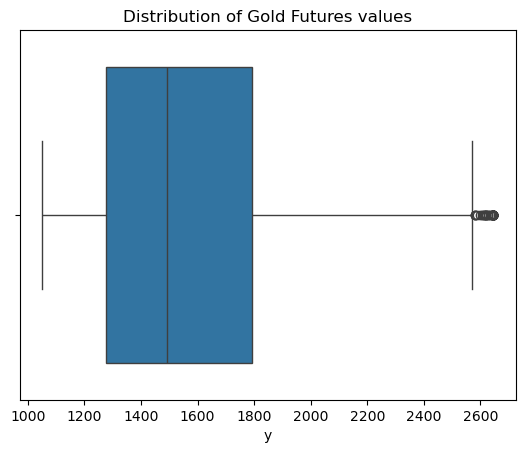

In [7]:
# ## Check for Outliers
# Simple method: visualize and identify extreme values
sns.boxplot(x=df['y'])
plt.title("Distribution of Gold Futures values")
plt.show()

# If extreme outliers are present, we could cap them or remove them:
# For demonstration, let's say we cap at the 99th percentile:
upper_bound = df['y'].quantile(0.99)
df['y'] = np.where(df['y'] > upper_bound, upper_bound, df['y'])


In [ ]:
# ## Stationarity Checks (For SARIMA)
# The Augmented Dickey-Fuller (ADF) test to check for stationarity:
result = adfuller(df['y'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the series is not stationary (high p-value), consider differencing or transforming:
if result[1] > 0.05:
    # For demonstration, we'll difference the data once:
    df['y_diff'] = df['y'].diff()
    df['y_diff'] = df['y_diff'].ffill()  # Forward fill the first NA
    diff_result = adfuller(df['y_diff'].dropna())
    print('\nAfter differencing:')
    print('ADF Statistic:', diff_result[0])
    print('p-value:', diff_result[1])

ADF Statistic: 0.44832694311209637
p-value: 0.9832149658507094

After differencing:
ADF Statistic: -61.4316210155838
p-value: 0.0


The data seems to be non-stationary, thus, we're going to difference once in SARIMAX

## Data Ready for Modeling
At this point, we have:
- A continuous daily series (ds)
- Missing values handled
- Possible stationarity achieved (if using SARIMA)
- Outliers addressed
- Sufficient data and known frequency

In [9]:
# For Prophet:
# - Prophet expects columns named 'ds' and 'y'.
# Make sure these columns exist and are properly set:
prophet_df = df[['ds', 'y']].copy()  # Prophet's base dataset

# For SARIMA:
# - Use either 'y' if stationary or differenced version 'y_diff'.
# - We'll demonstrate just taking 'y' if stationary now.

print("Data is ready for modeling with SARIMA and Prophet.")
print(prophet_df.head())

Data is ready for modeling with SARIMA and Prophet.
          ds            y
0 2015-03-09  1376.699951
1 2015-03-10  1371.099976
2 2015-03-11  1371.199951
3 2015-03-12  1335.099976
4 2015-03-13  1343.300049


## Summary
We've ensured:
- Proper datetime indexing and regular frequency
- Missing values handled
- Stationarity checked for SARIMA
- Outliers mitigated
- Sufficient historical data

Next steps:
- Implementing the models!